In [1]:
import glob

%matplotlib inline
import mne
import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns

# Figures inline and set visualization style
sns.set()
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fftpack import fft, fftfreq, ifft, irfft, rfft
from scipy.integrate import simps
from scipy.signal import butter, filtfilt, hilbert
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# First Step : Loading the data to be analyzed 

In [2]:
# read the excel files just in case 
patients_256 = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /Alle_patienten_256Hz.xlsx")
patients_250 = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /Alle_patienten_250Hz.xlsx")

### Here we change the names of some columns to work with them more easily later on 

In [3]:
patients_250 = patients_250.rename(columns = {"Burstsupressie (ja/nee)" : "BS",
                                                "Nummer" : "ID"})
patients_250 = patients_250.dropna(subset = ["ID"])
patients_250 = patients_250.astype({"ID" : int})
patients_250_ids = list(patients_250["ID"])

In [4]:
patients_256 = patients_256.rename(columns = {"Burstsupressie (ja/nee)" : "BS",
                                                "Nummer" : "ID"})
patients_256 = patients_256.dropna(subset = ["ID"])
patients_256 = patients_256.astype({"ID" : int})
patients_256_ids = list(patients_256["ID"])
#patients_df = pd.concat([patients_data, patients_data1])
#patients_df = patients_df.drop(["file code"], axis = 1)

### Read the signal data recorded from each patient 

In [5]:
patients = glob.glob("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /*.mat")
patient_files_250 = []
patient_files_256 = []

for i in range(0,len(patients)): 
    temp = patients[i].replace("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /patient_","")
    temp = int(temp.replace(".mat", ""))
    if temp in patients_250_ids:
        patient_files_250.append(patients[i])
    else:
        patient_files_256.append(patients[i])
    

### In the following code we define some information needed, such as channel names, trials and channel types to form the MNE signal objects, then define the channel locations and finally create the MNE Raw objects. 

In [6]:
# necessary information taken from the data in order to create MNE objects. 
channelLabels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8",
                "A1", "T3", "C3", "Cz", "C4", "T4", "A2", "T5", 
                "P3", "Pz", "P4", 'T6', '01', '02', 'ECG']
trials = 1 
n_channels = 22
ch_types = ['eeg'] * (n_channels-3)
ch_types.append('misc')
ch_types.append('misc')
ch_types.append('ecg')

In [7]:
def define_montage(type):
    '''method that helps us define the channel locations '''

    # Form the 10-20 montage 'standard_1020'
    mont1020 = mne.channels.make_standard_montage(type)
    # Choose what channels you want to keep 
    # Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
    kept_channels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8",
                "A1", "T3", "C3", "Cz", "C4", "T4", "A2", "T5", 
                "P3", "Pz", "P4", 'T6']
    ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
    mont1020_new = mont1020.copy()
    # Keep only the desired channels
    mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
    kept_channel_info = [mont1020.dig[x+3] for x in ind]
    # Keep the first three rows as they are the fiducial points information
    mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
    
    #mont1020.plot()
    #mont1020_new.plot()
    
    return mont1020_new

In [8]:
def create_Raw_objects(patient_list,channelLabels,n_channels,sampling_frequency,phase,types,ids):
    evoked_arrays = {}
    for i in range(0,len(patient_list)): 
        patient = scipy.io.loadmat(patient_list[i])
        samples = patient[phase]["data"][0][0]
        
        info = mne.create_info(
        ch_names = channelLabels, 
        ch_types = types,
        sfreq = sampling_frequency)
        
        info.set_montage(define_montage('standard_1020'))
        evoked_array = mne.io.RawArray(samples, info)
        evoked_arrays.update({ids[i] : evoked_array })
    return evoked_arrays

In [9]:
eeg_InDia_250 = create_Raw_objects(patient_files_250, channelLabels, n_channels, 250,"EEG_INDIA",ch_types,patients_250_ids);
eeg_InDia_256 = create_Raw_objects(patient_files_256,channelLabels, n_channels, 256, "EEG_INDIA", ch_types,patients_256_ids);
#eeg_PreOK = create_MNE_objects(patients, channelLabels, n_channels, sampling_frequency, "EEG_PreOK",ch_types)
#eeg_Klem = create_MNE_objects(patients, channelLabels, n_channels, sampling_frequency, "EEG_Klem",ch_types)

Creating RawArray with float64 data, n_channels=22, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.004 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=391128
    Range : 0 ... 391127 =      0.000 ...  1564.508 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=169409
    Range : 0 ... 169408 =      0.000 ...   677.632 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=291251
    Range : 0 ... 291250 =      0.000 ...  1165.000 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=162501
    Range : 0 ... 162500 =      0.000 ...   650.000 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=152051
    Range : 0 ... 152050 =      0.000 ...   608.200 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=369993
    Range : 0 ... 369992 =      0.000 ...  1479.968 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=501
    Range : 0 ... 500 =     

In [10]:
def remove_zero_times(raw_array,patient_ids) :
    """
    remove the instances with zero sampling time from the patients list as they include no signal information. 
    return the id of the patients with no signal data, and the new eeg signal list 
    """
    res = raw_array.copy() 
    for i in raw_array: 
        if raw_array[i].n_times == 0 or raw_array[i].n_times == 1:
            del res[i]
            patient_ids.remove(i)
    
    return res,patient_ids

In [11]:
eeg_india_250, patients_250_ids= remove_zero_times(eeg_InDia_250,patients_250_ids)
eeg_india_256, patients_256_ids = remove_zero_times(eeg_InDia_256,patients_256_ids)


In [12]:
eeg_india = {}
eeg_india.update(eeg_india_250)
eeg_india.update(eeg_india_256)

type(eeg_india)

dict

In [13]:
def create_windows(raw_array): 
    epochs_array = {}
    for i in raw_array: 
        epoch = mne.make_fixed_length_epochs(raw_array[i],duration = 2,preload=True)
        epochs_array[i] = epoch
    return epochs_array



In [14]:
epoched_eeg_india = create_windows(eeg_india);

Not setting metadata
782 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 782 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
338 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 338 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
582 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 582 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
325 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 325 events and 500 original time points ...
0 bad epochs dropped
Not setting metadata
304 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 304 events and 500 original time po

Using matplotlib as 2D backend.


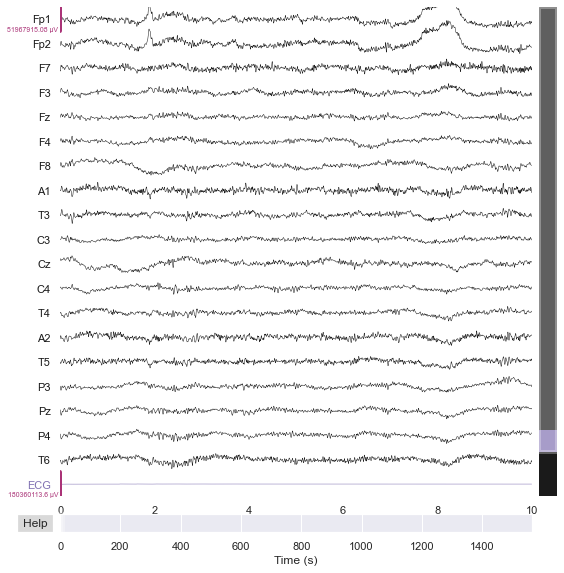

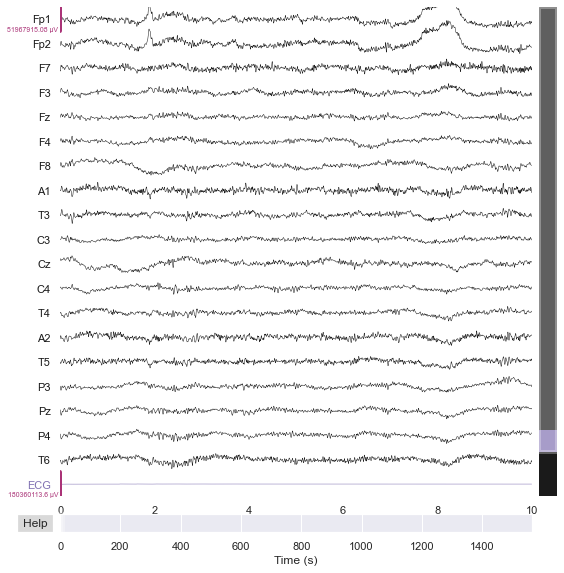

In [15]:
eeg_india[2].plot(scalings= "auto")

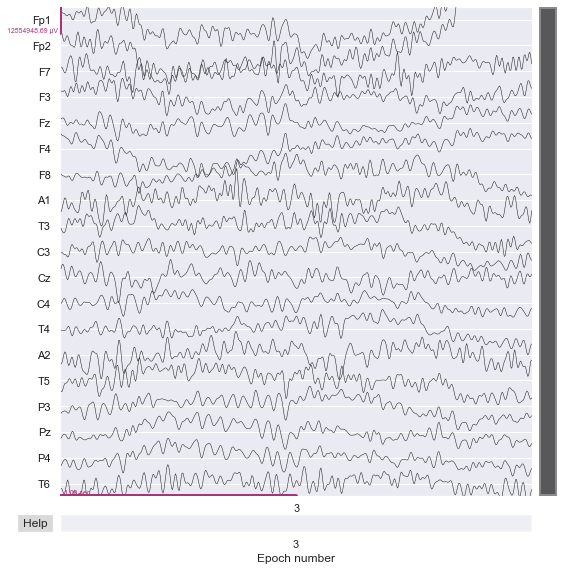

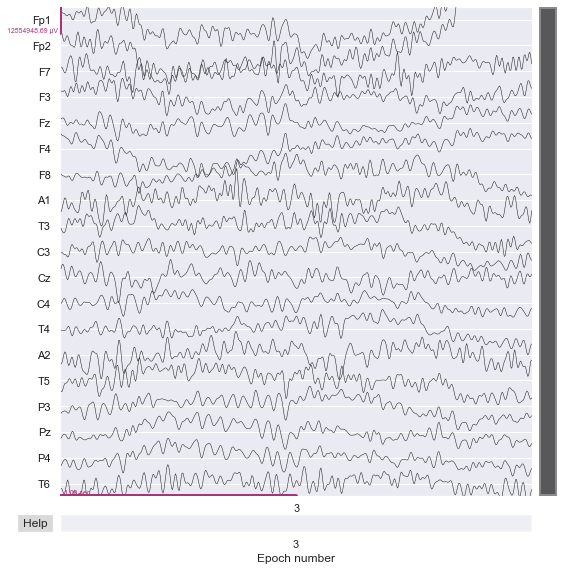

In [16]:
epoched_eeg_india[2][3].plot(scalings="auto")

## Time Domain Features 

In [17]:
## extract time-domain features 

def calculate_mean(raw_array, patient_ids):
    mean_dict = {}
    for i in patient_ids: 

        col_mean = raw_array[i].get_data().mean(axis = 1)
        mean = col_mean.mean()

        mean_dict.update({i : mean})
    return mean_dict


def standard_deviation(raw_array, patient_ids): 
    std_dict = {}
    for i in patient_ids: 

        col_std = raw_array[i].get_data().std(axis = 1)
        std = col_std.std()

        std_dict.update({i : std})
    return std_dict

In [18]:
epoched_eeg_india[2].get_data()[2]

array([[ 2.55837035,  4.01261187,  3.30604029, ...,  2.86647534,
         3.79763317,  4.07023001],
       [-3.30633807, -3.85731411, -4.62145948, ...,  2.39065456,
         4.27048159,  5.90326357],
       [ 7.59482718,  8.45123959,  6.72740746, ...,  3.12900162,
         2.00239301,  0.88161451],
       ...,
       [-3.78940558, -4.63612509, -4.34497499, ..., -1.62055552,
        -2.01966357, -2.58577681],
       [ 1.11537623,  0.17593214, -0.98279703, ..., -1.70632064,
        -3.26040363, -4.64283657],
       [ 0.15638125,  0.15476856,  0.15163268, ...,  0.30947447,
         0.30669317,  0.30820695]])

## Frequency Domain Transformation and Features

- Here the goal is to transform the signal data from each patient and extract the average power from each frequency band, to finally extract our features for the classification task. The signal data is transformed into the frequency domain using the Welch's method, then the average power is calculated by taking the area of interest, depending on the frequency band, under the curve. The same procedure is applied to each EEG channel. 
- As well as the mean power, the ratio between each band power, shannon entropy, which gives us information related to the periodicity of the signal is calculated. 

 -  delta (0.5–4 Hz)
  - theta (4–8 Hz)  
 -  alpha (8–12 Hz)
 -  beta (12–30 Hz)
 -  gamma (30–100 Hz)

In [28]:
def bandpower(data, sf, band, windowing = "hann", relative=False):
    """Compute the average power of the signal x in a specific frequency band.
        Absolute or relative band power.
    """
    from scipy.integrate import simps
    from scipy.signal import welch
    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, window=windowing)
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

def average_band_power(band, eeg_array,relative = False,windowing = "hann"):
    mean_bps = []
    bps = []
    for j in range(0,22): 
        bp = bandpower(eeg_array[j],250,band, windowing, relative = relative)
        bps.append(bp) 
    mean  = np.mean(bps)
    mean_bps.append(mean)
    return mean_bps

In [276]:
# eeg_india[16].compute_psd(window = "hann").plot(); 
# eeg_india[16].compute_psd(window = "hamming").plot(); 
# eeg_india[16].compute_psd(window = "blackman").plot(); 


83

In [29]:
mean_alpha =[]
mean_beta = []
mean_delta = []
mean_gamma = []
mean_theta = []
for i in epoched_eeg_india: 
    for e in range(0,len(epoched_eeg_india[i])):
        mean_power_delta = average_band_power([0.5,3.9],epoched_eeg_india[i].get_data()[e])
        mean_delta.append(mean_power_delta)
        mean_power_theta = average_band_power([4,7.9],epoched_eeg_india[i].get_data()[e])
        mean_theta.append(mean_power_theta)
        mean_power_alpha = average_band_power([8,11.9],epoched_eeg_india[i].get_data()[e])
        mean_alpha.append(mean_power_alpha)
        mean_power_beta = average_band_power([12,29.9],epoched_eeg_india[i].get_data()[e])
        mean_beta.append(mean_power_beta)
        mean_power_gamma = average_band_power([30,50],epoched_eeg_india[i].get_data()[e])
        mean_gamma.append(mean_power_gamma)

In [30]:
len(mean_alpha)

77693

In [164]:
def find_ratio(band1, band2): 
    ratio_array = []
    for i in range (0,len(band1)): 
        if(band1[i] == 0 or band2[i] == 0 ): 
            ratio = 0
        else:
            ratio = 1 / (band1[i] / band2[i])
        ratio_array.append(ratio)
    return ratio_array

In [165]:
delta_alpha = []
delta_beta = []
delta_theta = []
delta_gamma =[]
alpha_beta = []
alpha_theta = []
alpha_gamma = []
beta_theta = []
beta_gamma = []
theta_gamma = []

for i in range(0,len(mean_alpha)): 

    d_a = find_ratio(mean_delta[i],mean_alpha[i])
    delta_alpha.append(d_a)
    d_b= find_ratio(mean_delta[i],mean_beta[i])
    delta_beta.append(d_b)
    d_t = find_ratio(mean_delta[i],mean_theta[i])
    delta_theta.append(d_t)
    d_g = find_ratio(mean_delta[i],mean_gamma[i])
    delta_gamma.append(d_g)

    a_b = find_ratio(mean_alpha[i],mean_beta[i])
    alpha_beta.append(a_b)
    a_t = find_ratio(mean_alpha[i],mean_theta[i])
    alpha_theta.append(a_t)
    a_g = find_ratio(mean_alpha[i], mean_gamma[i])
    alpha_gamma.append(a_g)

    b_t = find_ratio(mean_beta[i],mean_theta[i])
    beta_theta.append(b_t)
    b_g = find_ratio(mean_beta[i],mean_gamma[i])
    beta_gamma.append(b_g)

    t_g = find_ratio(mean_theta[i],mean_gamma[i])
    theta_gamma.append(t_g)


len(theta_gamma)

77693

In [166]:
def calc_shannon_entropy(data_set):
    entropies = []
    
    probability = np.square(data_set)
    shannon_entropy = -np.nansum(probability * np.log2(probability))
    entropies.append(round(shannon_entropy, 3))
    return entropies

In [167]:
entropies = []
for i in epoched_eeg_india:
    for e in range(0,len(epoched_eeg_india[i] )): 
        shannon_entropy = calc_shannon_entropy(epoched_eeg_india[i].get_data()[e])
        entropies.append(shannon_entropy)

len(entropies)

77693

In [168]:
ids = patients_250_ids+ patients_256_ids


In [169]:
final_ids = []
id_to_add = []
for i in ids : 
    id_to_add.append(i)
    final_ids.extend(id_to_add * len(epoched_eeg_india[i]))
    id_to_add= []

len(final_ids)

77693

In [172]:
power_df = pd.DataFrame({"ID" : final_ids, 
                        "mean_alpha" : mean_alpha,
                        "mean_beta" : mean_beta, 
                        "mean_delta" : mean_delta, 
                        "mean_theta" : mean_theta, 
                        "mean_gamma" : mean_gamma,
                        "delta_alpha" : delta_alpha,
                        "delta_beta" : delta_beta,
                        "delta_theta" : delta_theta, 
                        "delta_gamma" : delta_gamma, 
                        "alpha_beta" : alpha_beta, 
                        "alpha_theta" : alpha_theta, 
                        "alpha_gamma": alpha_gamma, 
                        "beta_theta" : beta_theta,
                        "beta_gamma" : beta_gamma,
                        "theta_gamma" : theta_gamma,
                        "shannon_entropy" : entropies})

cols = power_df.drop("ID", axis = 1).columns
print(cols)

for col in cols : 
   power_df[col] = [','.join(map(str, l)) for l in power_df[col]]


power_df = power_df.apply(pd.to_numeric)

power_df



Index(['mean_alpha', 'mean_beta', 'mean_delta', 'mean_theta', 'mean_gamma',
       'delta_alpha', 'delta_beta', 'delta_theta', 'delta_gamma', 'alpha_beta',
       'alpha_theta', 'alpha_gamma', 'beta_theta', 'beta_gamma', 'theta_gamma',
       'shannon_entropy'],
      dtype='object')


,ID,mean_alpha,mean_beta,mean_delta,mean_theta,mean_gamma,delta_alpha,delta_beta,delta_theta,delta_gamma,alpha_beta,alpha_theta,alpha_gamma,beta_theta,beta_gamma,theta_gamma,shannon_entropy
0,2,1.495719,2.237249,4.108002,0.397896,0.826934,0.364099,0.544608,0.096859,0.201298,1.495768,0.266024,0.552867,0.177851,0.369621,2.078263,-2.000839e+06
1,2,1.217754,4.858363,2.982665,0.775166,0.892773,0.408277,1.628866,0.259891,0.299320,3.989610,0.636554,0.733131,0.159553,0.183760,1.151718,-1.261781e+06
2,2,0.416347,3.792234,1.471910,0.492407,0.785068,0.282862,2.576403,0.334536,0.533367,9.108351,1.182684,1.885611,0.129846,0.207020,1.594348,-5.904249e+05
3,2,0.512750,3.350728,2.891530,0.903370,0.950324,0.177328,1.158808,0.312419,0.328658,6.534819,1.761813,1.853387,0.269604,0.283617,1.051977,-2.348455e+06
4,2,0.644184,2.308426,12.819466,0.685809,0.847123,0.050250,0.180072,0.053497,0.066081,3.583490,1.064617,1.315033,0.297089,0.366970,1.235217,-6.202473e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77688,378,25.342944,12.192477,603.476944,219.382160,2.885840,0.041995,0.020204,0.363530,0.004782,0.481099,8.656538,0.113872,17.993240,0.236690,0.013154,-1.869434e+08
77689,378,22.707040,11.218667,560.405400,152.786627,2.731924,0.040519,0.020019,0.272636,0.004875,0.494061,6.728602,0.120312,13.618965,0.243516,0.017881,-5.916466e+08
77690,378,30.742187,19.190514,988.771072,85.675185,0.853082,0.031091,0.019408,0.086648,0.000863,0.624240,2.786893,0.027750,4.464455,0.044453,0.009957,-7.860021e+08
77691,378,34.934768,17.164318,262.053143,115.152141,0.820376,0.133312,0.065499,0.439423,0.003131,0.491325,3.296205,0.023483,6.708810,0.047795,0.007124,-1.043442e+08


In [173]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):

    import matplotlib.pyplot as plt
    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import periodogram, welch
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax2.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax1.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax2.plot(freqs, psd, lw=lw, color=lc)
    ax1.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB / Hz)')
    ax2.set_title('Periodogram')
    ax1.set_title('Mean-power Alpha Band')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()


In [174]:
plot_spectrum_methods(eeg_india[16].get_data()[2], 250, 4, band=[4,7], dB=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


NOTE: plot_psd_topo() is a legacy function. New code should use .compute_psd().plot_topo().
Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


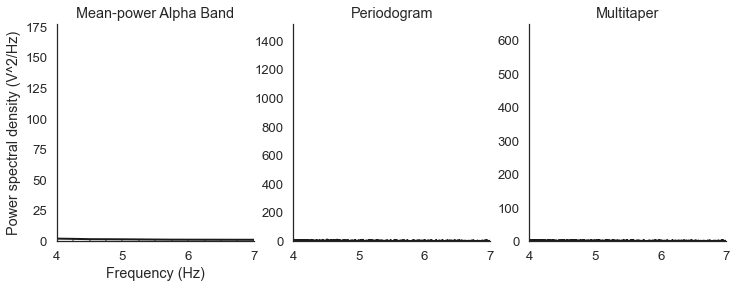

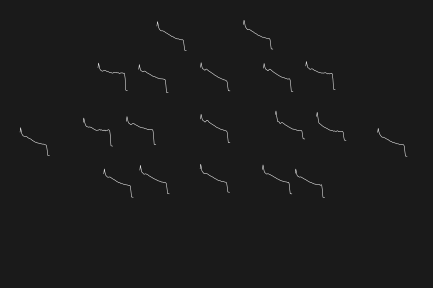

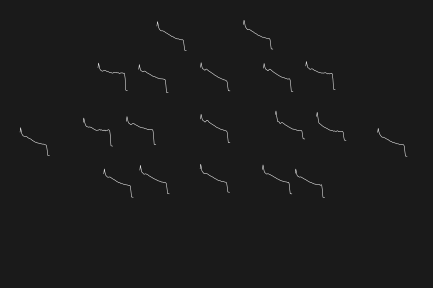

In [175]:
eeg_india[16].plot_psd_topo(fmax = 50)


Effective window size : 1.024 (s)


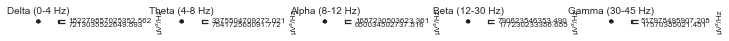

In [35]:
eeg_india[16].compute_psd().plot_topomap();

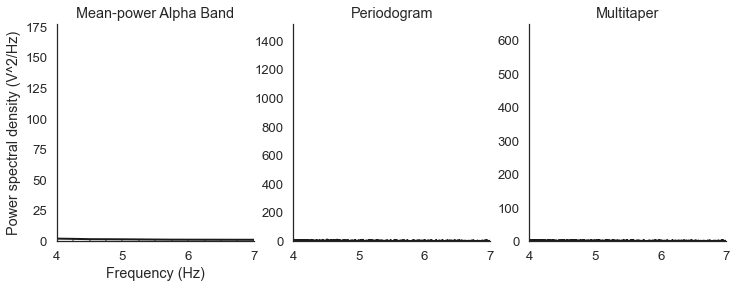

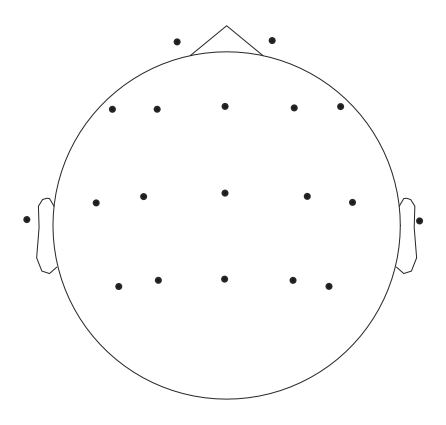

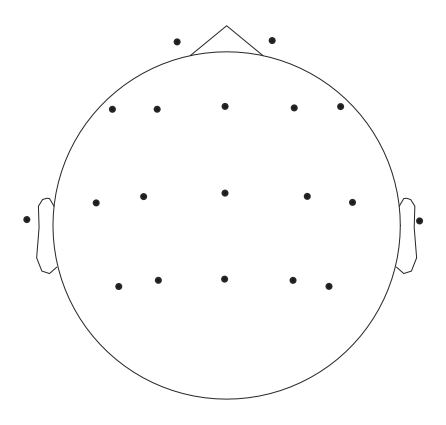

In [71]:
eeg_india[16].plot_sensors(ch_type = "eeg")

# EDA and Feature Selection 

In [176]:
patients_df = patients_250.append(patients_256,ignore_index=True)
patients_df = patients_df[patients_df["ID"].isin(ids)]
print(type(power_df))

additional = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /additional_data.xlsx")
additional = additional.rename(columns={"Subject_no" : "ID"})
additional= additional[additional["ID"].isin(ids)]


patients_df = pd.merge(patients_df,power_df,on = "ID")
patients_df.drop(["Tijdstip ogen dicht", "Tijdstip ogen open", "tijdstip tweede ogen dicht", "tijdstip tweede ogen open", 
                   "tijdstip derde ogen dicht","tijdstip derde ogen open", "Tijdstip start op OK","Tijdstip start inleiding",'Tijdstip start diathermie', 'Tijdstip start klem', 'Duur klem',
       'Tijdstip einde OK', 'file code','opm'], inplace=True, axis=1)
    
patients_df["BS"] = patients_df["BS"].map({'ja' : 1, 'nee' : 0})

final_df = pd.merge(patients_df,additional, on = "ID")

final_df


<class 'pandas.core.frame.DataFrame'>


,ID,BS,Age at OR,mean_alpha,mean_beta,mean_delta,mean_theta,mean_gamma,delta_alpha,delta_beta,...,RRdiastolic3minutesafterclampingmmHg,RRdiastolicrightafterclampreleasemmHg,RRdiastolic1minuteafterclampreleasemmHg,RRdiastolic3minutesafterclampreleasemmHg,RRdiastolicendofORmmHg,meanmicroembolismduringOR≈,summicroembolismduringOR,meanmicroembolismafterOR≈,summicroembolismafterendofOR,interventionbecauseofMES
0,2,NaN,78.168378,1.495719,2.237249,4.108002,0.397896,0.826934,0.364099,0.544608,...,81.0,77.0,78.0,78.0,0.0,NaN,22,0,0,0.0
1,2,NaN,78.168378,1.217754,4.858363,2.982665,0.775166,0.892773,0.408277,1.628866,...,81.0,77.0,78.0,78.0,0.0,NaN,22,0,0,0.0
2,2,NaN,78.168378,0.416347,3.792234,1.471910,0.492407,0.785068,0.282862,2.576403,...,81.0,77.0,78.0,78.0,0.0,NaN,22,0,0,0.0
3,2,NaN,78.168378,0.512750,3.350728,2.891530,0.903370,0.950324,0.177328,1.158808,...,81.0,77.0,78.0,78.0,0.0,NaN,22,0,0,0.0
4,2,NaN,78.168378,0.644184,2.308426,12.819466,0.685809,0.847123,0.050250,0.180072,...,81.0,77.0,78.0,78.0,0.0,NaN,22,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77688,378,0.0,61.207392,25.342944,12.192477,603.476944,219.382160,2.885840,0.041995,0.020204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77689,378,0.0,61.207392,22.707040,11.218667,560.405400,152.786627,2.731924,0.040519,0.020019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77690,378,0.0,61.207392,30.742187,19.190514,988.771072,85.675185,0.853082,0.031091,0.019408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77691,378,0.0,61.207392,34.934768,17.164318,262.053143,115.152141,0.820376,0.133312,0.065499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Selection  : 
 - The first step is to handle the columns with missing values; in this case I removed the columns that have a missing value ratio of 20% 
 - Second is to apply a high correlation filter so that we get rid of the columns that are redundant 

In [179]:
def remove_uninformative_features(df): 
    uninformative_features = []
    for i in df.columns: 
        if (i != "BS") & (df[i].isna().sum()/df.shape[0] * 100 >= 15): 
            uninformative_features.append(i)
    new_df = df.drop(uninformative_features, axis = 1)
    return new_df

In [86]:
def low_variance_filter(df): 
    uninformative_features = []
    for i in df.columns: 
        if (i != "BS") & (df[i].var() <= 1.1): 
            uninformative_features.append(i)
    new_df = df.drop(uninformative_features, axis = 1)
    return new_df

In [180]:
final_df = final_df.drop(["Dosage_etomidate","Length", "Weight","latencyofclampingtoEEGchangesminutes",
             "Age at OR","Hypertension_tom", "kindofcomplication1","Antihypertensiva_recovery" ],axis = 1)
final_df = remove_uninformative_features(final_df)


In [88]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):

#     print(corrFilter(final_df,0.7))

In [181]:
final_df = final_df.drop(["ID",'shunting', 'shunt_indication', 'complication',
            'Deathin90days', 'latency',
       'vertebral_artery_stenosis'],axis =1)
final_df.columns

Index(['BS', 'mean_alpha', 'mean_beta', 'mean_delta', 'mean_theta',
       'mean_gamma', 'delta_alpha', 'delta_beta', 'delta_theta', 'delta_gamma',
       'alpha_beta', 'alpha_theta', 'alpha_gamma', 'beta_theta', 'beta_gamma',
       'theta_gamma', 'shannon_entropy', 'Gender', 'Age_OR', 'Smoking',
       'hypertension', 'diabetes', 'obesity', 'dyslipidaemia',
       'coronar_artery_disease', 'PAD', 'symptomatic_stenosis',
       'Kind_of_symptomatic_TIAstroke', 'localisation_of_operation',
       'type_of_operation', 'contralateral_stenosis',
       'degree_of_contralateral_stenosis_NASCET', 'clamping_time_min',
       'EEGchanges', 'TIA', 'Stroke', 'MI', 'Nervedamage',
       'postopbleedingIntracranicalHemorrhage', 'preop_aspirin',
       'preop_clopidogrel', 'preop_statins', 'preop_dipyridamol',
       'preop_vit_K_antagonit', 'preop_antihypertensives', 'preop_DOAC_NOAC',
       'preop_other_anticoagualation', 'intraoperative_protamine',
       'postop_antihypertensives', 'TCD'],
  

In [182]:
annotated_df  = final_df[final_df["BS"].notna()]
not_annotated_df = final_df[final_df["BS"].isna()]
# sns.countplot(x='BS', data=annotated_df)
annotated_df

,BS,mean_alpha,mean_beta,mean_delta,mean_theta,mean_gamma,delta_alpha,delta_beta,delta_theta,delta_gamma,...,preop_clopidogrel,preop_statins,preop_dipyridamol,preop_vit_K_antagonit,preop_antihypertensives,preop_DOAC_NOAC,preop_other_anticoagualation,intraoperative_protamine,postop_antihypertensives,TCD
3071,1.0,58.640056,31.532441,3565.657489,335.519487,3.878816,0.016446,0.008843,0.094098,0.001088,...,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
3072,1.0,299.444630,95.021607,41392.820489,5217.600093,38.082322,0.007234,0.002296,0.126051,0.000920,...,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
3073,1.0,159.522580,23.099381,498.115896,43.587062,3.358733,0.320252,0.046374,0.087504,0.006743,...,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
3074,1.0,131.755915,15.618326,447.236768,131.748789,3.570949,0.294600,0.034922,0.294584,0.007984,...,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
3075,1.0,90.994674,21.580315,40005.731655,363.760472,18.290850,0.002275,0.000539,0.009093,0.000457,...,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77688,0.0,25.342944,12.192477,603.476944,219.382160,2.885840,0.041995,0.020204,0.363530,0.004782,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
77689,0.0,22.707040,11.218667,560.405400,152.786627,2.731924,0.040519,0.020019,0.272636,0.004875,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
77690,0.0,30.742187,19.190514,988.771072,85.675185,0.853082,0.031091,0.019408,0.086648,0.000863,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
77691,0.0,34.934768,17.164318,262.053143,115.152141,0.820376,0.133312,0.065499,0.439423,0.003131,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [183]:
sns.countplot(x = "Gender",data=annotated_df,hue = "BS")

<AxesSubplot:xlabel='Gender', ylabel='count'>

In [184]:
sns.histplot(x = "Age_OR", data=annotated_df,hue="BS")

<AxesSubplot:xlabel='Gender', ylabel='count'>

In [185]:
## fill in the missing values 
annotated_df["type_of_operation"].fillna(annotated_df["type_of_operation"].mode()[0], inplace=True)
annotated_df["clamping_time_min"].fillna(annotated_df["clamping_time_min"].mean(), inplace= True)


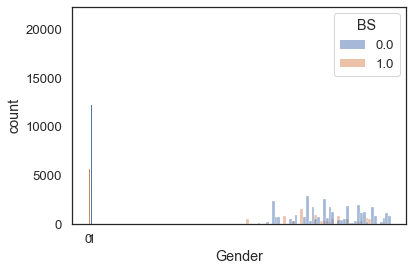

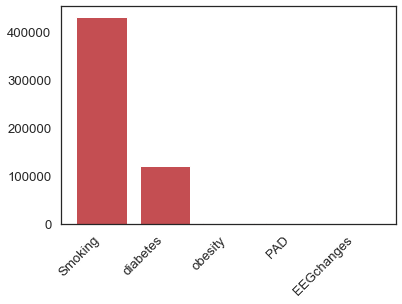

In [186]:
from sklearn.feature_selection import SelectKBest,chi2,f_classif
X = annotated_df[['Gender', 'Smoking', 'hypertension',
       'diabetes', 'obesity', 'dyslipidaemia', 'coronar_artery_disease', 'PAD',
       'symptomatic_stenosis','EEGchanges','TCD']]
y = annotated_df["BS"]
X = X.astype(int)
chi2_selector = SelectKBest(chi2, k = 5)
chi2_selector.fit(X,y)
chi2_scores = pd.DataFrame(list(zip(X.columns, chi2_selector.scores_, chi2_selector.pvalues_)), columns=['ftr', 'score', 'pval'])
chi2_scores

kbest = np.asarray(X.columns)[chi2_selector.get_support()]
kbest
indices = np.argsort(chi2_selector.scores_)[::-1]
plt.figure()
plt.bar(kbest, chi2_selector.scores_[indices[range(5)]], color='r', align='center')
plt.xticks(rotation=45, ha='right')
plt.show()

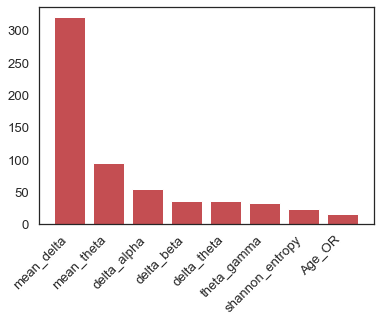

In [187]:
anova_selector = SelectKBest(score_func=f_classif,k = 8)
X = annotated_df[['mean_alpha', 'mean_delta', 'mean_theta',
       'mean_gamma', 'delta_alpha',
       'delta_beta', 'delta_theta', 'delta_gamma', 'beta_theta', 'beta_gamma', 'theta_gamma',
       'shannon_entropy','Age_OR']]
y = annotated_df["BS"]
anova_selector.fit(X,y)
anova_scores = pd.DataFrame(list(zip(X.columns, anova_selector.scores_, anova_selector.pvalues_)), columns=['ftr', 'score', 'pval'])
anova_scores

kbest = np.asarray(X.columns)[anova_selector.get_support()]
kbest

indices = np.argsort(anova_selector.scores_)[::-1]
plt.figure()
plt.bar(kbest, anova_selector.scores_[indices[range(8)]], color='r', align='center')
plt.xticks(rotation=45, ha='right')
plt.show()

In [188]:
selected_annotated_df = annotated_df[['mean_delta','mean_alpha','mean_theta', 'mean_gamma', 'delta_gamma',
'theta_gamma',"shannon_entropy",'Age_OR','Gender',"BS"]]
#selected_annotated_df['EEGchanges'] = selected_annotated_df["EEGchanges"].replace([999],selected_annotated_df["EEGchanges"].mode())
selected_annotated_df = selected_annotated_df.reset_index()
selected_annotated_df = selected_annotated_df.drop("index", axis=1)
selected_annotated_df

,mean_delta,mean_alpha,mean_theta,mean_gamma,delta_gamma,theta_gamma,shannon_entropy,Age_OR,Gender,BS
0,3565.657489,58.640056,335.519487,3.878816,0.001088,0.011561,-1.490656e+09,76.889802,0,1.0
1,41392.820489,299.444630,5217.600093,38.082322,0.000920,0.007299,-1.169077e+10,76.889802,0,1.0
2,498.115896,159.522580,43.587062,3.358733,0.006743,0.077058,-4.411991e+08,76.889802,0,1.0
3,447.236768,131.755915,131.748789,3.570949,0.007984,0.027104,-2.538197e+08,76.889802,0,1.0
4,40005.731655,90.994674,363.760472,18.290850,0.000457,0.050283,-1.321645e+10,76.889802,0,1.0
...,...,...,...,...,...,...,...,...,...,...
43165,603.476944,25.342944,219.382160,2.885840,0.004782,0.013154,-1.869434e+08,61.207392,1,0.0
43166,560.405400,22.707040,152.786627,2.731924,0.004875,0.017881,-5.916466e+08,61.207392,1,0.0
43167,988.771072,30.742187,85.675185,0.853082,0.000863,0.009957,-7.860021e+08,61.207392,1,0.0
43168,262.053143,34.934768,115.152141,0.820376,0.003131,0.007124,-1.043442e+08,61.207392,1,0.0


## Classification 

TODO : Implement Stratified K fold CV 
 - scores to consider : precision, recall, f1, AUC 

 - choose the best K for CV and threshold for f1 score. 

In [189]:
from numpy import *
from sklearn import metrics, model_selection, tree, preprocessing, svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.metrics import precision_score,recall_score,roc_auc_score,f1_score,confusion_matrix,roc_curve,auc
from sklearn.model_selection import StratifiedKFold,GridSearchCV,RandomizedSearchCV,train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

In [190]:
feature_cols = selected_annotated_df.drop("BS", axis=1)
X = feature_cols
y = selected_annotated_df.BS


### Stratified K-Fold Cross Validation 

In [191]:
print("Class Ratio : ", sum(selected_annotated_df["BS"]) / len(selected_annotated_df["BS"]))
skf = StratifiedKFold(n_splits= 5)
target = selected_annotated_df.loc[:,"BS"]

fold = 1
for train_index,test_index in skf.split(selected_annotated_df,target):
    train = selected_annotated_df.loc[train_index,:]
    test = selected_annotated_df.loc[test_index,:]
    print("Fold",str(fold),"Class Ratio : ", sum(test["BS"]) / len(test["BS"]))
    fold +=1


Class Ratio :  0.2236275191104934
Fold 1 Class Ratio :  0.22365068334491545
Fold 2 Class Ratio :  0.22365068334491545
Fold 3 Class Ratio :  0.22365068334491545
Fold 4 Class Ratio :  0.22365068334491545
Fold 5 Class Ratio :  0.2235348621728052


In [192]:
def train_model(train,test,fold_no,model,X = None):
    if(X is None):
         X = selected_annotated_df.drop("BS", axis=1).columns
    y = ["BS"]

    X_train = train[X]
    y_train = train[y]

    X_test = test[X]
    y_test = test[y]

    model.fit(X_train,y_train)
    predictions = model.predict(X_test)

    prec = precision_score(y_test,predictions)
    recall = recall_score(y_test,predictions)
    f1 = f1_score(y_test,predictions)
    auc_score = roc_auc_score(y_test,predictions)
    fpr, tpr, threshold = metrics.roc_curve(y_test,predictions)
    roc_auc = metrics.auc(fpr,tpr)

    # plt.title('Receiver Operating Characteristic')
    # plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    # plt.legend(loc = 'lower right')
    # plt.plot([0, 1], [0, 1],'r--')
    # plt.xlim([0, 1])
    # plt.ylim([0, 1])
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.show()





    

    return prec,recall,f1,auc_score,fpr,tpr,roc_auc
   # print("Fold", str(fold_no), "Precision: ",precision_score(y_test,predictions)
    #    ,"Recall : ", recall_score(y_test,predictions), "F1-score : ", f1_score(y_test,predictions))


In [193]:
def validate(model,X = None):
    fold_no =1
    prec = []
    recall = []
    f1 = []
    auc = []
    fprs =[]
    tprs = []
    for train_index,test_index in skf.split(selected_annotated_df,target):
        train = selected_annotated_df.loc[train_index,:]
        test = selected_annotated_df.loc[test_index,:]
        p,r,f,a,fpr,tpr,roc_auc = train_model(train,test,fold_no,model,X)
        prec.append(p)
        recall.append(r)
        f1.append(f)
        auc.append(a)
        fprs.append(fpr)
        tprs.append(tpr)
        fold_no+=1
    print("Model : ", str(model), "Precision: ", sum(prec) / len(prec),"Recall : ", sum(recall)/len(recall), "F1-score : ", sum(f1)/len(f1),"AUC : ",sum(auc)/len(auc))



In [194]:
decision_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5)
random_forest_clf = RandomForestClassifier(max_depth = 7, n_estimators=250)
xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state = 42)
log_res = LogisticRegression()
#support_vector = svm.SVC(kernel="poly")

In [195]:
validate(decision_tree)

validate(random_forest_clf)

validate(xgb_classifier)

validate(log_res)

#validate(svm)

Model :  DecisionTreeClassifier(criterion='entropy', max_depth=5) Precision:  0.20440881763527052 Recall :  0.027964785085447957 F1-score :  0.04911663566153673 AUC :  0.49455825409725185
Model :  RandomForestClassifier(max_depth=7, n_estimators=250) Precision:  0.21823827429122514 Recall :  0.052725399334018465 F1-score :  0.08377685799677484 AUC :  0.5089983200229429
Model :  XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estim

In [58]:
rfc_parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
}

cv = GridSearchCV(random_forest_clf,rfc_parameters,cv=5)
cv.fit(X,y.ravel())

def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

display(cv)

Best parameters are: {'max_depth': 16, 'n_estimators': 50}


0.743 + or -0.005 for the {'max_depth': 2, 'n_estimators': 5}
0.731 + or -0.009 for the {'max_depth': 2, 'n_estimators': 10}
0.726 + or -0.005 for the {'max_depth': 2, 'n_estimators': 50}
0.726 + or -0.005 for the {'max_depth': 2, 'n_estimators': 100}
0.726 + or -0.005 for the {'max_depth': 2, 'n_estimators': 250}
0.765 + or -0.031 for the {'max_depth': 4, 'n_estimators': 5}
0.805 + or -0.036 for the {'max_depth': 4, 'n_estimators': 10}
0.807 + or -0.031 for the {'max_depth': 4, 'n_estimators': 50}
0.81 + or -0.032 for the {'max_depth': 4, 'n_estimators': 100}
0.815 + or -0.028 for the {'max_depth': 4, 'n_estimators': 250}
0.953 + or -0.03 for the {'max_depth': 8, 'n_estimators': 5}
0.956 + or -0.023 for the {'max_depth': 8, 'n_estimators': 10}
0.983 + or -0.013 for the {'max_depth': 8, 'n_estimators': 50}
0.988 + or -0.014 for the {'max_depth': 8, 'n_estimators': 100}
0.988 + or -0.008 for the {'max_depth': 8, 'n_estimators'

No handles with labels found to put in legend.


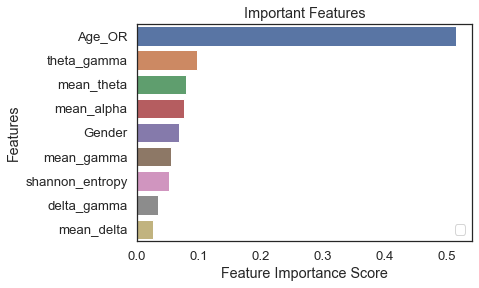

In [196]:
feature_imp = pd.Series(random_forest_clf.feature_importances_,index=X.columns).sort_values(ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features")
plt.legend()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

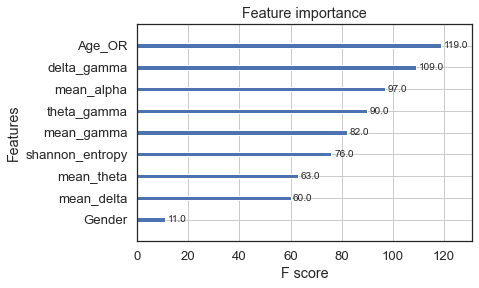

In [60]:
xgb.plot_importance(xgb_classifier)


## Logistic Regression and SVM

## SHAP Explanations

In [198]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.34)

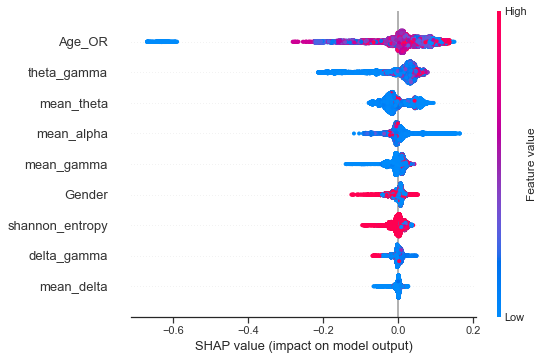

In [199]:
import shap
random_forest_clf.fit(X_train,Y_train)
f = plt.figure()
shap_values_rfc = shap.TreeExplainer(random_forest_clf).shap_values(X_train)
shap.summary_plot(shap_values_rfc[0],X_train,plot_type="dot")

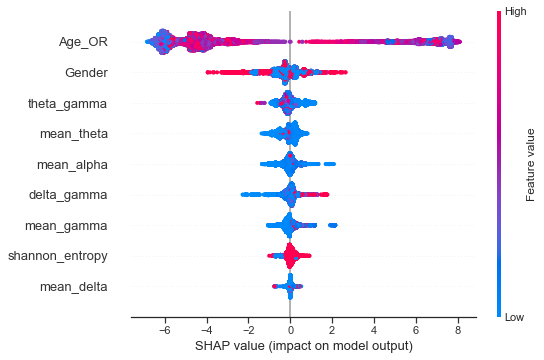

In [200]:
xgb_classifier.fit(X_train,Y_train)
f = plt.figure()
shap_values_xgb = shap.TreeExplainer(xgb_classifier).shap_values(X_train)
shap.summary_plot(shap_values_xgb,X_train)

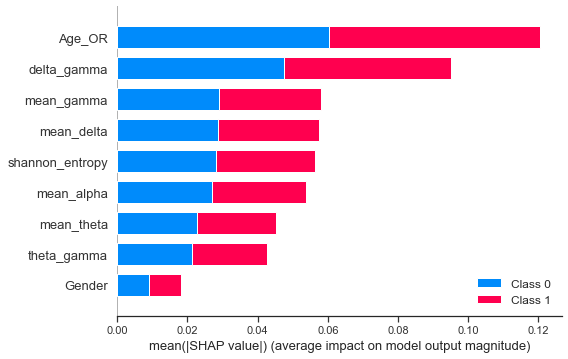

In [64]:
shap.summary_plot(shap_values_rfc,X_train,plot_type = "bar")

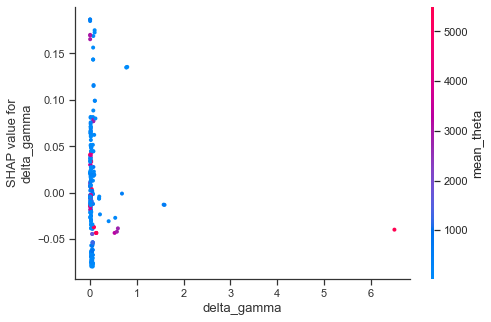

In [65]:
shap.dependence_plot("delta_gamma", shap_values_rfc[1], X_train)